In [77]:
import requests
import pandas as pd
from tqdm import tqdm
import folium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
url_inventory_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt"
url_stations_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"
url_countries_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-countries.txt"
url_states_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-states.txt"
url_state_raw = "https://raw.githubusercontent.com/georgique/world-geojson/develop/states/usa/new_hampshire.json"

In [79]:
def parse_stations_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "ID": line[0:11].strip(),
                "LATITUDE": float(line[12:20].strip()),
                "LONGITUDE": float(line[21:30].strip()),
                "ELEVATION": float(line[31:37].strip()),
                "STATE": line[38:40].strip(),
                "NAME": line[38:68].strip(),
            })
    return pd.DataFrame(data)

def parse_inventory_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "ID": line[0:11].strip(),
                "LATITUDE": float(line[12:20].strip()),
                "LONGITUDE": float(line[21:30].strip()),
                "ELEMENT": line[31:35].strip(),
                "FIRSTYEAR": int(line[36:40].strip()),
                "LASTYEAR": int(line[41:45].strip())
            })
    return pd.DataFrame(data)

def parse_countries_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "CODE": line[0:2].strip(),
                "NAME": line[3:64].strip()
            })
    return pd.DataFrame(data)

def parse_states_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "CODE": line[0:2].strip(),
                "NAME": line[3:50].strip()
            })
    return pd.DataFrame(data)

def parse_data_dly(line):
    data = []
    for i in range(21, 269, 8):
        value = int(line[i:i+5])
        mflag = line[i+5]
        qflag = line[i+6]
        sflag = line[i+7]
        data.extend([value, mflag, qflag, sflag])
    return {
        "ID": line[0:11].strip(),
        "YEAR": int(line[11:15]),
        "Month": int(line[15:17]),
        "ELEMENT": line[17:21].strip(),
        "DATA": data
    }

def read_data_from_url(url):
    data = []
    response = requests.get(url)
    if response.status_code == 200:
        for line in response.text.splitlines():
            data.append(parse_data_dly(line))
    else:
        print(f"Failed to retrieve data for {url}. Status code: {response.status_code}")
    return data

def fetch_and_save_to_dataframe(station_ids):
    all_data = []
    for station_id in tqdm(station_ids, desc="Fetching Data", unit="station", ncols=100):
        url = f"https://www.ncei.noaa.gov/pub/data/ghcn/daily/all/{station_id}.dly"
        data = read_data_from_url(url)
        all_data.extend(data)
    headers = ["ID", "YEAR", "Month", "ELEMENT"]
    for i in range(1, 32):
        headers.extend([f"VALUE{i}", f"MFLAG{i}", f"QFLAG{i}", f"SFLAG{i}"])
    df_data = []
    for entry in all_data:
        row = [entry["ID"], entry["YEAR"], entry["Month"], entry["ELEMENT"]]
        row.extend(entry["DATA"])
        df_data.append(row)
    return pd.DataFrame(df_data, columns=headers)


In [80]:
inventory = parse_inventory_txt(url_inventory_txt)
stations= parse_stations_txt(url_stations_txt)
countries = parse_countries_txt(url_countries_txt)
states = parse_states_txt(url_states_txt)

In [81]:
# For country
#s_country_list = stations[stations['ID'].str.startswith('US')]['ID'].tolist()
# For state
s_state_list=stations[stations['STATE']=='NH']['ID'].tolist()
s_live_list=inventory[(inventory['ID'].isin(s_state_list)) & (inventory['LASTYEAR']>=2024)]['ID'].unique().tolist()
result = inventory.loc[inventory['ID'].isin(s_live_list), ['ID', 'ELEMENT', 'FIRSTYEAR', 'LASTYEAR']]
result['YEAR_DIFF'] = result['LASTYEAR'] - result['FIRSTYEAR']
Req_station_list = pd.Series(result[(result['YEAR_DIFF'] >= 50) & (result['LASTYEAR'] > 2014)]['ID'].tolist()).unique()

In [82]:
data= fetch_and_save_to_dataframe(Req_station_list)

Fetching Data: 100%|███████████████████████████████████████████| 28/28 [00:09<00:00,  3.02station/s]


In [83]:
flag_columns = [col for col in data.columns if 'FLAG' in col]
data= data.drop(columns=flag_columns)
data.replace(-9999.0, np.nan, inplace=True)

In [84]:
weather_variables = ['TMAX', 'TMIN', 'SNOW', 'SNWD', 'PRCP']
data=data[data['ELEMENT'].isin(weather_variables)]

In [85]:
from collections import defaultdict
station_year_month = data.groupby(['ID', 'YEAR', 'Month']).size().reset_index(name='count')
missing_by_station = defaultdict(list)
stations_with_more_than_10_missing_years = []
for station in data['ID'].unique():
    min_year = data[data['ID'] == station]['YEAR'].min()
    max_year = data[data['ID'] == station]['YEAR'].max()
    all_years = range(min_year, max_year)  
    all_months = range(1, 13)
    all_combinations = pd.MultiIndex.from_product([all_years, all_months], names=['YEAR', 'Month'])
    all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()
    station_data = station_year_month[station_year_month['ID'] == station]
    merged_data = pd.merge(all_combinations_df, station_data, on=['YEAR', 'Month'], how='left')
    missing_data = merged_data[merged_data['count'].isna()]
    missing_pairs = missing_data[['YEAR', 'Month']].itertuples(index=False, name=None)
    for pair in missing_pairs:
        missing_by_station[station].append((pair[0], pair[1]))

for station, pairs in missing_by_station.items():
    min_year = data[data['ID'] == station]['YEAR'].min()
    max_year = data[data['ID'] == station]['YEAR'].max()
    years_missing = set([year for year, _ in pairs]) 
    months_missing = set([month for _, month in pairs])
    fully_missing_years = [year for year in years_missing if len(months_missing) == 12]
    if len(fully_missing_years) > 10:
        stations_with_more_than_10_missing_years.append(station)
stations_to_print = [station for station in missing_by_station.keys() if station not in stations_with_more_than_10_missing_years]


In [86]:
data=data[data['ID'].isin(stations_to_print)]

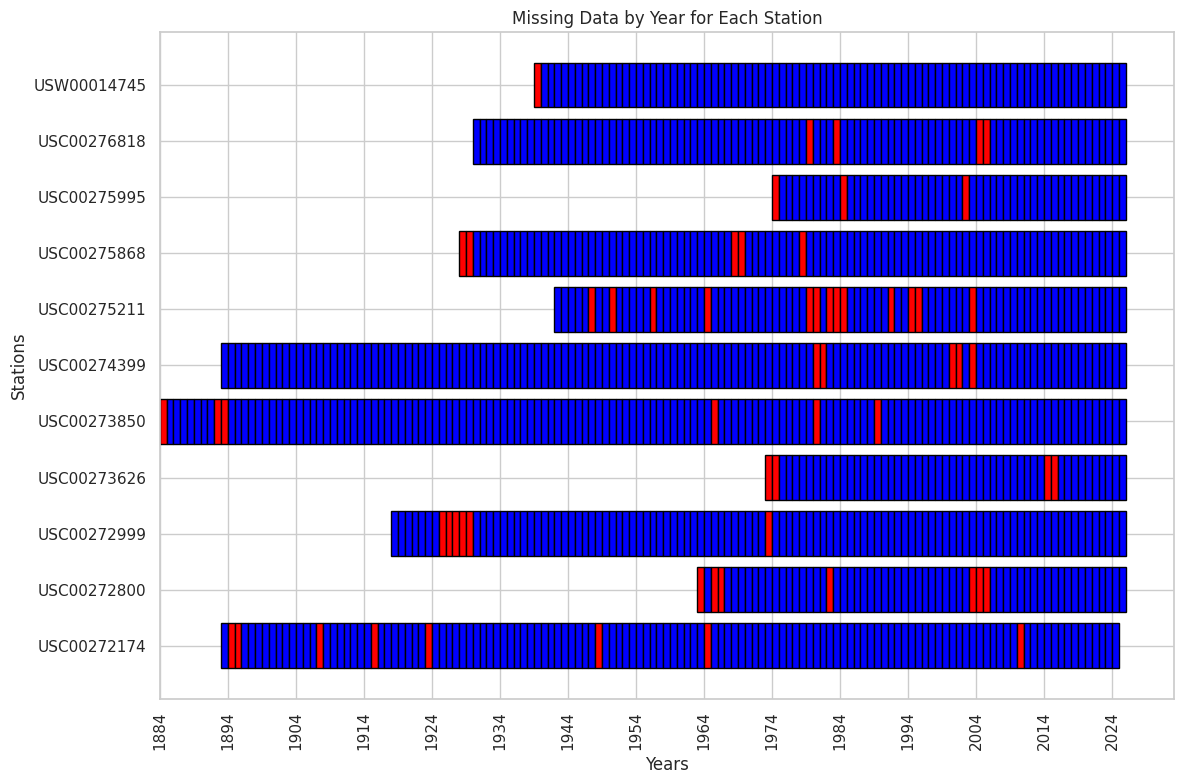

In [87]:
# Create the figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Create a color map for missing data and available data
missing_color = 'red'
available_color = 'blue'

# Find the overall min and max year across all stations
min_overall_year = min([data[data['ID'] == station]['YEAR'].min() for station in stations_to_print])
max_overall_year = max([data[data['ID'] == station]['YEAR'].max() for station in stations_to_print])

# Loop over each station to create the plot
for idx, station in enumerate(stations_to_print):
    # Get the min and max years for the station
    min_year = data[data['ID'] == station]['YEAR'].min()
    max_year = data[data['ID'] == station]['YEAR'].max()

    # Ensure min_year and max_year are different
    if min_year == max_year:
        continue

    # Generate a 2D grid for years (x-axis) and months (y-axis) if the years are valid
    if min_year < max_year:
        years = np.arange(min_year, max_year + 1)

        # Initialize a matrix to represent data availability (1 for missing data, 0 for available data)
        availability_matrix = np.zeros(len(years))

        # Mark missing year-month pairs
        for year, _ in missing_by_station.get(station, []):
            year_indices = np.where(years == year)
            if year_indices[0].size > 0:
                year_idx = year_indices[0][0]
                availability_matrix[year_idx] = 1  # Mark missing data as 1

        # Create bars for each year, marking missing data in red and available data in blue
        for i, year in enumerate(years):
            if availability_matrix[i] == 1:
                ax.barh(idx, 1, left=year, height=0.8, color=missing_color, edgecolor='black')
            else:
                ax.barh(idx, 1, left=year, height=0.8, color=available_color, edgecolor='black')

# Set labels and title
ax.set_xlabel('Years')
ax.set_ylabel('Stations')
ax.set_title('Missing Data by Year for Each Station')

# Customize year labels on x-axis: show first, last, and every 10th year
x_ticks = [min_overall_year] + list(range(min_overall_year + 10, max_overall_year, 10)) 
ax.set_xticks(x_ticks)

# Customize station names on y-axis
ax.set_yticks(np.arange(len(stations_to_print)))
ax.set_yticklabels(stations_to_print)  # Use the stations_to_print list

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=90)

# Add grid
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
state_stations = stations[stations['STATE']=='NH']
state_lat = state_stations['LATITUDE'].mean()
state_lon = state_stations['LONGITUDE'].mean()
state_map = folium.Map(location=[state_lat, state_lon], 
                       zoom_start=7.5,
                       min_zoom=6,
                       max_zoom=10)

stations_to_plot = stations[stations['ID'].isin(stations_to_print)]
for _, row in stations_to_plot.iterrows():
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=row['NAME'],
        tooltip=row['NAME']
    ).add_to(state_map)
try:
    geojson_data = requests.get(url_state_raw).json() 
    folium.GeoJson(geojson_data, name="State Boundary").add_to(state_map)
except Exception as e:
    print(f"Error loading GeoJSON: {e}")
    
state_map

In [89]:
data.tail()


,ID,YEAR,Month,ELEMENT,VALUE1,VALUE2,VALUE3,VALUE4,VALUE5,VALUE6,...,VALUE22,VALUE23,VALUE24,VALUE25,VALUE26,VALUE27,VALUE28,VALUE29,VALUE30,VALUE31
154801,USW00014745,2025,2,TMAX,-5.0,-60.0,39.0,22.0,-60.0,-66.0,...,17.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154802,USW00014745,2025,2,TMIN,-149.0,-232.0,-88.0,-93.0,-177.0,-199.0,...,-105.0,-77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154803,USW00014745,2025,2,PRCP,13.0,18.0,15.0,0.0,0.0,104.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154804,USW00014745,2025,2,SNOW,15.0,23.0,10.0,0.0,0.0,76.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154805,USW00014745,2025,2,SNWD,152.0,152.0,178.0,127.0,102.0,178.0,...,330.0,330.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
import pandas as pd

# Filter data to only include snow (SNOW) elements
snow_data = data[data['ELEMENT'] == 'SNOW']

# Extract the relevant columns (Month and all VALUE columns)
snow_data_values = snow_data[['ID', 'YEAR', 'Month', 'VALUE1', 'VALUE2', 'VALUE3', 'VALUE4', 'VALUE5', 'VALUE6', 
                              'VALUE7', 'VALUE8', 'VALUE9', 'VALUE10', 'VALUE11', 'VALUE12', 'VALUE13', 'VALUE14',
                              'VALUE15', 'VALUE16', 'VALUE17', 'VALUE18', 'VALUE19', 'VALUE20', 'VALUE21', 'VALUE22', 
                              'VALUE23', 'VALUE24', 'VALUE25', 'VALUE26', 'VALUE27', 'VALUE28', 'VALUE29', 'VALUE30', 'VALUE31']]

# Count the number of days with snowfall (non-NaN and non-zero snowfall values)
snow_data_values['snow_days'] = snow_data_values.iloc[:, 3:].apply(lambda row: (row > 0).sum(), axis=1)

# Count the total number of days in each month (in this case, it's always 31 days)
snow_data_values['total_days'] = 31

# Calculate the percentage of days with snow for each month
snow_data_values['snow_percentage'] = snow_data_values['snow_days'] / snow_data_values['total_days'] * 100

# Group by the 'Month' and find the average percentage of snow across all years for that month
monthly_snow_percentage = snow_data_values.groupby('Month')['snow_percentage'].mean().reset_index()

# Sort the months by snowfall percentage in descending order to find the month with the highest snowfall percentage
monthly_snow_percentage_sorted = monthly_snow_percentage.sort_values(by='snow_percentage', ascending=False)

# Display the month with the highest snowfall percentage
print(monthly_snow_percentage_sorted)


    Month  snow_percentage
0       1        27.053457
1       2        23.668987
11     12        23.114412
2       3        18.870304
10     11         9.640951
3       4         7.156836
9      10         1.468572
4       5         0.624595
7       8         0.125156
8       9         0.023895
6       7         0.016169
5       6         0.008054


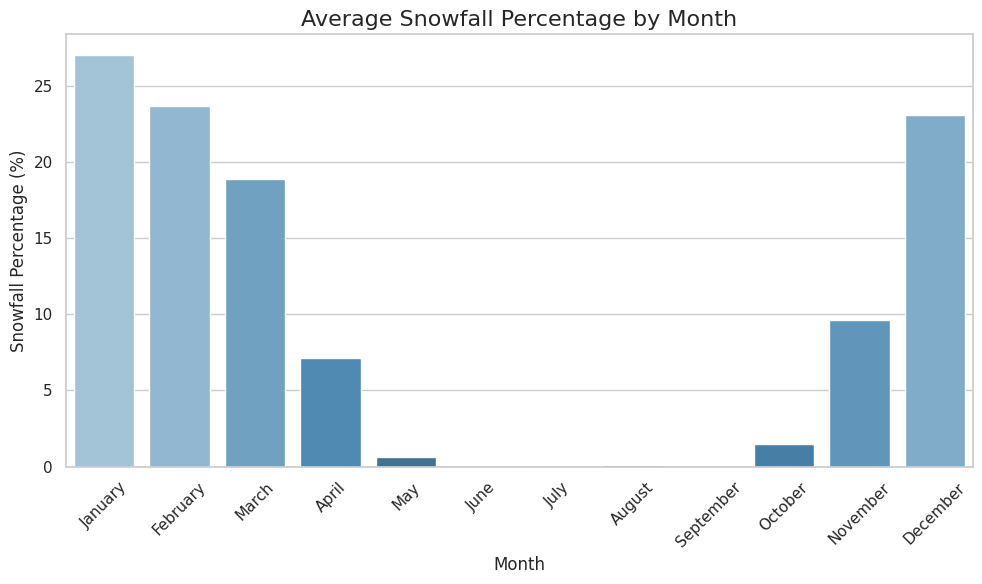

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming monthly_snow_percentage_sorted is the DataFrame with the calculated snow percentages

# If 'Month' is a string with month names, map to month numbers
month_name_to_num = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# If the 'Month' is already numeric, skip this step
if isinstance(monthly_snow_percentage_sorted['Month'].iloc[0], str):
    monthly_snow_percentage_sorted['Month'] = monthly_snow_percentage_sorted['Month'].map(month_name_to_num)

# Map numeric months to month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_snow_percentage_sorted['Month'] = monthly_snow_percentage_sorted['Month'].apply(lambda x: month_names[x - 1])

# Set the order of months to ensure they are in the correct chronological order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Set the visual style for the plot
sns.set(style="whitegrid")

# Create the bar plot with 'hue' set to 'Month' and 'legend' set to False to avoid the warning
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='snow_percentage', data=monthly_snow_percentage_sorted, hue='Month', palette='Blues_d', order=month_order, legend=False)

# Add title and labels
plt.title('Average Snowfall Percentage by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Snowfall Percentage (%)', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [93]:
import pandas as pd
import os

# Function to extract and save individual variable dataframes
def extract_and_save_variable_dataframes(df, variables, output_dir='Data/Variable_Data'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    dataframes = {}
    for var in variables:
        var_df = df[df['ELEMENT'] == var].copy()
        dataframes[var] = var_df
        var_df.to_csv(f'{output_dir}/{var}_data.csv', index=False)
        
    return dataframes

# Function to transform data to daily records
def transform_to_daily_data(df, element):
    # Initialize a list to store transformed data
    transformed_data = []
    
    # Loop over each row (station data) in the DataFrame
    for _, row in df.iterrows():
        # Get the station's ID, season, and month values
        station_id = row['ID']
        year = row['YEAR']
        month = row['Month']
        
        # Loop through each day's value in the row (VALUE1 to VALUE31)
        for day in range(1, 32):
            # Construct the date for each day
            date_str = f"{year}-{month:02d}-{day:02d}"
            
            # Get the value for that day (e.g., VALUE1 corresponds to day 1, VALUE2 to day 2, etc.)
            value_column = f'VALUE{day}'
            element_value = row.get(value_column, None)
            
            # If the value exists (not NaN), create a new record for that day
            if pd.notna(element_value):
                transformed_data.append({
                    'DATE': date_str,
                    'ID': station_id,
                    element: element_value
                })
    
    # Convert the list of transformed data into a DataFrame
    transformed_df = pd.DataFrame(transformed_data)
    return transformed_df

# Function to transform all variable dataframes into daily records and save the transformed data
def transform_all_variables_to_daily_data(variable_dfs, output_dir='Data/Transform_Data'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Loop through each variable dataframe and transform it to daily data
    for var, df in variable_dfs.items():
        transformed_df = transform_to_daily_data(df, var)
        
        # Save the transformed data for each variable to a CSV file
        transformed_df.to_csv(f'{output_dir}/{var}_data.csv', index=False)

# Example usage:

# Assuming 'data' is your original DataFrame and 'weather_variables' contains the list of variable names
# Extract and save data for each variable
variable_dfs = extract_and_save_variable_dataframes(data, weather_variables)

# Transform the saved data to daily records and save the output
transform_all_variables_to_daily_data(variable_dfs)


In [94]:
import pandas as pd
import glob

def combine_csv_files(directory_path: str) -> pd.DataFrame:
    # List all CSV files from the specified directory
    csv_files = glob.glob(f'{directory_path}/*_data.csv')

    # Check if there are any files found
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in the directory: {directory_path}")

    # Start by reading the first CSV file
    combined_df = pd.read_csv(csv_files[0])

    # Loop through the rest of the CSV files and merge them one by one
    for file in csv_files[1:]:
        df = pd.read_csv(file)
        
        # Rename columns to avoid conflicts (split by the first '_' to avoid suffixes like 'Season_x', 'Season_y')
        df = df.rename(columns=lambda x: x.split('_')[0] if '_' in x else x)

        # Merge on 'ID' and 'DATE' columns, with suffixes to prevent naming conflicts
        combined_df = pd.merge(combined_df, df, on=['ID', 'DATE'], how='outer', suffixes=('_left', '_right'))

    # Return the combined DataFrame
    return combined_df


combined_df = combine_csv_files('Data/Transform_Data')

# Display the first few rows of the combined DataFrame
print(combined_df.head())


         DATE           ID  SNWD  SNOW   TMIN  TMAX   PRCP
0  1893-01-01  USC00272174   NaN   NaN -111.0  22.0  198.0
1  1893-01-02  USC00272174   NaN   NaN  -56.0  94.0    0.0
2  1893-01-03  USC00272174   NaN   NaN  -78.0  94.0    0.0
3  1893-01-04  USC00272174   NaN   NaN -172.0  -6.0    0.0
4  1893-01-05  USC00272174   NaN   NaN -128.0 -17.0    0.0


In [95]:
import pandas as pd

# Function to add the 'Season' column
def add_season_column(df):
    # Convert 'DATE' column to datetime format if it's not already
    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
    
    # Define a function to assign seasons based on month
    def get_season(month):
        if month in [12, 1, 2]:  # Winter: Dec, Jan, Feb
            return 'Winter'
        elif month in [3, 4, 5]:  # Spring: Mar, Apr, May
            return 'Spring'
        elif month in [6, 7, 8]:  # Summer: Jun, Jul, Aug
            return 'Summer'
        else:  # Fall: Sep, Oct, Nov
            return 'Fall'
    
    # Apply the function to create the 'Season' column based on the month of the 'DATE'
    df['Season'] = df['DATE'].dt.month.apply(get_season)
    
    return df

# Example usage:
# Assuming 'combined_df' is your DataFrame

# Add the 'Season' column
combined_df = add_season_column(combined_df)

# Display the updated DataFrame
print(combined_df.head())


        DATE           ID  SNWD  SNOW   TMIN  TMAX   PRCP  Season
0 1893-01-01  USC00272174   NaN   NaN -111.0  22.0  198.0  Winter
1 1893-01-02  USC00272174   NaN   NaN  -56.0  94.0    0.0  Winter
2 1893-01-03  USC00272174   NaN   NaN  -78.0  94.0    0.0  Winter
3 1893-01-04  USC00272174   NaN   NaN -172.0  -6.0    0.0  Winter
4 1893-01-05  USC00272174   NaN   NaN -128.0 -17.0    0.0  Winter


In [96]:
column_order = ['DATE','ID', 'Season','TMIN', 'TMAX', 'PRCP', 'SNOW', 'SNWD']

# Reorder the DataFrame columns
combined_df = combined_df[column_order]

In [97]:
# Function to process columns, divide by 10, and update column names with units
def process_columns_with_units(df, columns_to_divide, units):
    # Ensure the relevant columns are numeric (force conversion and handle errors)
    for col in columns_to_divide:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Coerce invalid values to NaN
    
    # Divide the relevant columns by 10 and add units
    for col in columns_to_divide:
        df[col] = df[col] / 10  # Divide by 10 as needed
        # Update column name to include unit
        df.rename(columns={col: f"{col} ({units[col]})"}, inplace=True)
    
    return df

columns_to_divide = ['TMIN', 'TMAX', 'PRCP']
units = {
    'TMIN': '°C',   # Minimum temperature in tenths of °C
    'TMAX': '°C',   # Maximum temperature in tenths of °C
    'PRCP': 'mm',   # Precipitation in tenths of mm
    'SNOW': 'mm',   # Snowfall in mm
    'SNWD': 'mm',   # Snow depth in mm 
}

# Apply the function to your DataFrame
combined_df = process_columns_with_units(combined_df, columns_to_divide, units)

# Display the updated DataFrame
print(combined_df.head())


        DATE           ID  Season  TMIN (°C)  TMAX (°C)  PRCP (mm)  SNOW  SNWD
0 1893-01-01  USC00272174  Winter      -11.1        2.2       19.8   NaN   NaN
1 1893-01-02  USC00272174  Winter       -5.6        9.4        0.0   NaN   NaN
2 1893-01-03  USC00272174  Winter       -7.8        9.4        0.0   NaN   NaN
3 1893-01-04  USC00272174  Winter      -17.2       -0.6        0.0   NaN   NaN
4 1893-01-05  USC00272174  Winter      -12.8       -1.7        0.0   NaN   NaN


In [98]:
combined_df.to_csv('Data/Final.csv', index=False)

In [99]:
import pandas as pd

# Function to calculate correlation for each season
def correlation_by_season(df):
    # First, group the data by 'Season'
    seasons = df['Season'].unique()
    
    # Create an empty dictionary to store correlation matrices for each season
    correlation_matrices = {}
    
    # Iterate through each season and calculate correlation
    for season in seasons:
        season_df = df[df['Season'] == season]
        
        # Only keep the numerical columns for correlation calculation
        numerical_columns = season_df.select_dtypes(include='number')
        
        # Calculate the correlation matrix for the season's data
        correlation_matrix = numerical_columns.corr()
        
        # Store the correlation matrix in the dictionary
        correlation_matrices[season] = correlation_matrix
    
    return correlation_matrices

# Example usage:
# Assuming 'combined_df' is your DataFrame with the 'Season' column added

# Calculate correlation for each season
correlation_matrices = correlation_by_season(combined_df)

# Display correlation matrices for each season
for season, corr_matrix in correlation_matrices.items():
    print(f"Correlation Matrix for {season}:")
    print(corr_matrix)
    print("\n")


Correlation Matrix for Winter:
           TMIN (°C)  TMAX (°C)  PRCP (mm)      SNOW      SNWD
TMIN (°C)   1.000000   0.750076   0.233136 -0.006964 -0.379507
TMAX (°C)   0.750076   1.000000   0.152859 -0.135253 -0.354718
PRCP (mm)   0.233136   0.152859   1.000000  0.513798  0.057838
SNOW       -0.006964  -0.135253   0.513798  1.000000  0.256718
SNWD       -0.379507  -0.354718   0.057838  0.256718  1.000000


Correlation Matrix for Spring:
           TMIN (°C)  TMAX (°C)  PRCP (mm)      SNOW      SNWD
TMIN (°C)   1.000000   0.760047   0.126426 -0.178088 -0.515235
TMAX (°C)   0.760047   1.000000  -0.102132 -0.273941 -0.507501
PRCP (mm)   0.126426  -0.102132   1.000000  0.343684  0.039699
SNOW       -0.178088  -0.273941   0.343684  1.000000  0.320243
SNWD       -0.515235  -0.507501   0.039699  0.320243  1.000000


Correlation Matrix for Summer:
           TMIN (°C)  TMAX (°C)  PRCP (mm)      SNOW      SNWD
TMIN (°C)   1.000000   0.508022   0.142513  0.004667 -0.000728
TMAX (°C)   0.508022 

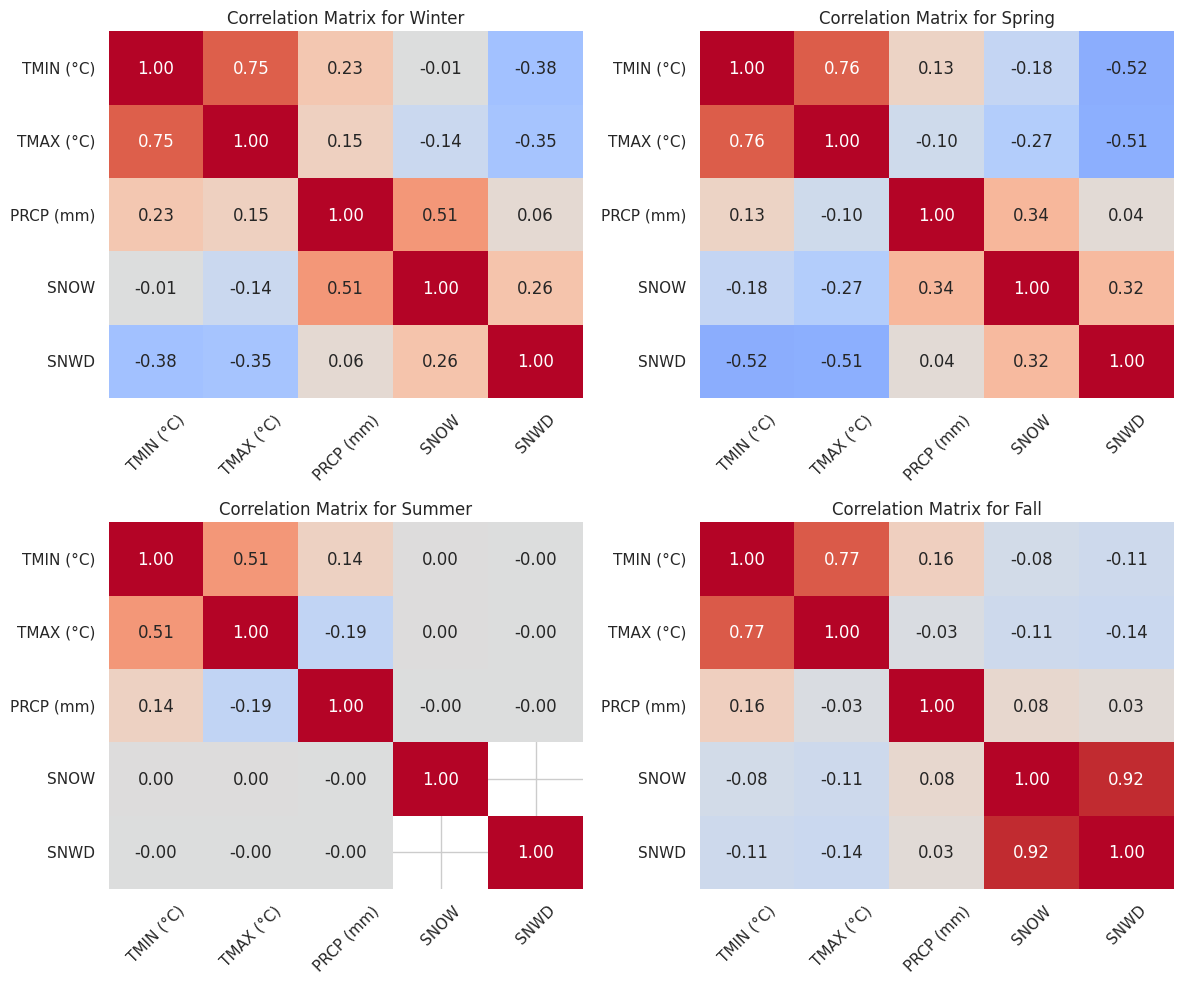

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot correlation for all seasons in a single figure with 4 quadrants
def plot_seasonal_correlations_in_quadrants(correlation_matrices):
    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust the size of the figure
    
    # Iterate over the seasons and their corresponding subplot axes
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    for i, (season, corr_matrix) in enumerate(correlation_matrices.items()):
        row = i // 2  # Determine row (0 or 1)
        col = i % 2   # Determine column (0 or 1)
        
        # Plot the heatmap for each season in the corresponding subplot
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, 
                    ax=axes[row, col], cbar=False, fmt='.2f')
        
        # Set the title and axis labels for each subplot
        axes[row, col].set_title(f'Correlation Matrix for {season}')
        axes[row, col].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
        axes[row, col].tick_params(axis='y', rotation=0)   # Keep y-axis labels upright
    
    # Adjust the layout to prevent overlap and show the figure
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'correlation_matrices' is a dictionary with the correlation matrices for each season
plot_seasonal_correlations_in_quadrants(correlation_matrices)


In [102]:
df=pd.read_csv('Data/Final.csv')

In [103]:
# Check if there is snowfall or not
snowy_days = df[df['SNOW'] > 0]  # Days with snowfall
non_snowy_days = df[df['SNOW'] <= 0]  # Days without snowfall

# Display the number of snowy and non-snowy days
print(f"Number of snowy days: {len(snowy_days)}")
print(f"Number of non-snowy days: {len(non_snowy_days)}")

# Optionally, you can display the first few rows of snowy and non-snowy days to inspect
print("\nSample of snowy days:")
print(snowy_days.head())

print("\nSample of non-snowy days:")
print(non_snowy_days.head())


Number of snowy days: 33787
Number of non-snowy days: 277941

Sample of snowy days:
           DATE           ID  Season  TMIN (°C)  TMAX (°C)  PRCP (mm)   SNOW  \
599  1895-11-22  USC00272174    Fall      -10.0       -2.8        2.5   25.0   
612  1895-12-05  USC00272174  Winter       -7.2       -2.8        NaN  102.0   
645  1896-01-07  USC00272174  Winter      -21.1      -11.1        NaN   13.0   
648  1896-01-10  USC00272174  Winter       -8.9       -2.8        NaN  152.0   
650  1896-01-12  USC00272174  Winter      -18.3       -1.1        NaN   25.0   

     SNWD  
599   NaN  
612   NaN  
645   NaN  
648   NaN  
650   NaN  

Sample of non-snowy days:
           DATE           ID Season  TMIN (°C)  TMAX (°C)  PRCP (mm)  SNOW  \
578  1895-11-01  USC00272174   Fall       -1.7       11.7       53.3   0.0   
579  1895-11-02  USC00272174   Fall       -0.6        5.6       10.2   0.0   
580  1895-11-03  USC00272174   Fall       -0.6        6.7        0.0   0.0   
581  1895-11-04  USC0027

In [105]:
df.columns

Index(['DATE', 'ID', 'Season', 'TMIN (°C)', 'TMAX (°C)', 'PRCP (mm)', 'SNOW',
       'SNWD'],
      dtype='object')

In [110]:
# Descriptive statistics for snowy days
print("\nDescriptive statistics for snowy days:")
print(snowy_days[['TMIN (°C)', 'TMAX (°C)', 'PRCP (mm)', 'SNOW', 'SNWD']].describe().round(2))

# Descriptive statistics for non-snowy days
print("\nDescriptive statistics for non-snowy days:")
print(non_snowy_days[['TMIN (°C)', 'TMAX (°C)', 'PRCP (mm)', 'SNOW', 'SNWD']].describe().round(2))

# You can also compare the average temperature for snowy and non-snowy days
print("\nAverage temperatures for snowy and non-snowy days:")
print(f"Average TMIN for snowy days: {snowy_days['TMIN (°C)'].mean().round(2)}")
print(f"Average TMAX for snowy days: {snowy_days['TMAX (°C)'].mean().round(2)}")
print(f"Average TMIN for non-snowy days: {non_snowy_days['TMIN (°C)'].mean().round(2)}")
print(f"Average TMAX for non-snowy days: {non_snowy_days['TMAX (°C)'].mean().round(2)}")



Descriptive statistics for snowy days:
       TMIN (°C)  TMAX (°C)  PRCP (mm)      SNOW      SNWD
count   32309.00   32311.00   33491.00  33787.00  29540.00
mean       -9.93      -0.52       7.02     59.14    330.72
std         6.95       5.25       9.06     80.27    329.78
min       -71.10     -26.10       0.00      3.00      0.00
25%       -14.40      -3.30       1.30     13.00    102.00
50%        -8.90       0.00       3.80     38.00    254.00
75%        -4.40       2.80       9.40     76.00    483.00
max        20.60      32.20     158.00   7884.00  20396.00

Descriptive statistics for non-snowy days:
       TMIN (°C)  TMAX (°C)  PRCP (mm)      SNOW       SNWD
count  255664.00  255748.00  275003.00  277941.0  249541.00
mean        1.74      14.41       2.63       0.0      59.15
std        10.46      10.96       7.67       0.0     165.85
min       -71.10     -31.10       0.00       0.0       0.00
25%        -4.40       6.10       0.00       0.0       0.00
50%         2.20      15.